In [1]:
from trnasimtools.serialize import SerializeTwoCodonSingleTranscript
import os

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
#!mkdir ../yaml/may-3-2022
#!mkdir ../output/may-3-2022

In [3]:
date="may-3-2022"

In [4]:
# simulation parameters
time_limit = 500
time_step = 5
transcript_len = 100
trna_props = [1, 2, 5, 10, 20, 30, 40, 45, 48, 49, 50, 51, 52, 55, 60, 70, 80, 90, 95, 98, 99]
codon_comps = range(1, 100)
transcript_copy_number = 100
ribosome_copy_number = 100
total_trna = 100
ribosome_binding_rate = 100000.0
trna_charging_rates = [10.0, 100.0, 1000.0, 10000.0, 100000.0, 1000000.0]

In [5]:
# create configuration files for each codon ratio/tRNA ratio combination
configs = os.listdir(f"../yaml/{date}")
for i in trna_props:
    for j in codon_comps:
        trna1_prop, trna2_prop = (i/100, (100-i)/100)
        codon1_prop, codon2_prop = (j/100, (100-j)/100)
        serializer = SerializeTwoCodonSingleTranscript(transcript_len=transcript_len,
                                                   codon_comp=(codon1_prop, codon2_prop),
                                                   trna_proportion=(trna1_prop, trna2_prop),
                                                   time_limit=time_limit,
                                                   time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [12]:
# write simulation command file (5 simulations per config, per charging rate)
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for trna_charging_rate in trna_charging_rates:
            for seed in range(1, 6):
                cmd = f"python3 twocodonsingletranscript.py ../yaml/{date}/{config} {seed} {transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ribosome_binding_rate} {trna_charging_rate} {trna_charging_rate} ../output/{date}"
                stream.write(cmd)
                stream.write("\n")

In [ ]:
# (actual simulations run directly on the server)

In [6]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = pd.read_csv(f"{path}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    if tmp.empty:
        times = df_master["time"].to_list()
        dedup_times = []
        [dedup_times.append(x) for x in times if x not in dedup_times]
        next_best_time = take_closest(dedup_times, time)
        tmp = df_master.loc[df_master['time'] == next_best_time].groupby(["species"])["protein"].mean().reset_index()
    tmp["codon_comp"] = perc_good
    return tmp

In [7]:
df_master = None

for count, trna_charging_rate in enumerate(trna_charging_rates):
    df_tmp = None
    for trna_prop1 in trna_props:
        for codon_comp1 in codon_comps:
            codon_comp2 = 100 - codon_comp1
            trna_prop2 = 100 - trna_prop1
            path = f"../output/{date}/two_codon_single_transcript_{codon_comp1/100}_{codon_comp2/100}_{trna_prop1/100}_{trna_prop2/100}" + \
                   f"_{transcript_copy_number}_{ribosome_copy_number}_{total_trna}_{ribosome_binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            try:
                tmp = get_average_protein(path, codon_comp1, 500, 5)
            except FileNotFoundError as e:
                continue
            tmp["tRNA_prop"] = trna_prop1
            if df_tmp is not None:
                df_tmp = df_tmp.append(tmp, ignore_index=True)
            else:
                df_tmp = tmp
    df_tmp["tRNA_charging_rate"] = str(trna_charging_rate)
    if df_master is not None:
        df_master = df_master.append(df_tmp, ignore_index=True)
    else:
        df_master = df_tmp
df_master

,species,protein,codon_comp,tRNA_prop,tRNA_charging_rate
0,ATA_charged,18.666667,1,1,10.0
1,ATA_uncharged,80.333333,1,1,10.0
2,TTT_charged,0.000000,1,1,10.0
3,TTT_uncharged,1.000000,1,1,10.0
4,__proteinX_rbs,96.666667,1,1,10.0
...,...,...,...,...,...
82021,TTT_charged,98.200000,99,99,1000000.0
82022,TTT_uncharged,0.800000,99,99,1000000.0
82023,__proteinX_rbs,97.600000,99,99,1000000.0
82024,__ribosome,15.400000,99,99,1000000.0


In [10]:
#df_master.to_csv(f"../processed_data/{date}-averages-500-s.csv")

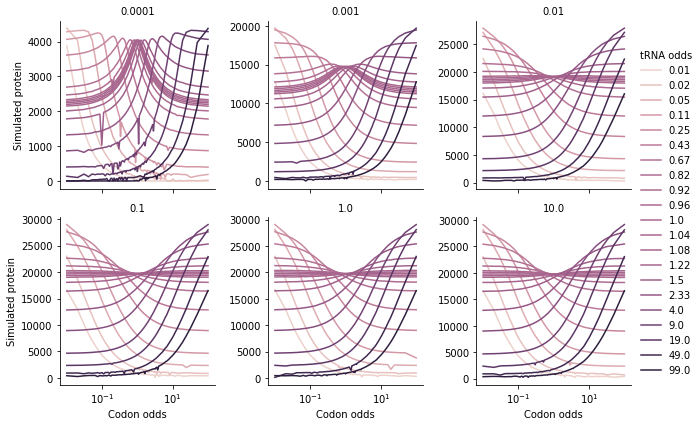

In [8]:
df_master = pd.read_csv(f"../processed_data/{date}-averages-500-s.csv")
norm = LogNorm()
df_master = df_master[(df_master.species == "proteinX")]
df_master['codon_odds'] = df_master.apply(lambda row: row.codon_comp/(100 - row.codon_comp), axis = 1)
df_master['fraction_preferred'] = df_master.apply(lambda row: row.codon_comp/100, axis = 1)
df_master['tRNA_odds'] = df_master.apply(lambda row: row.tRNA_prop/(100 - row.tRNA_prop), axis = 1)
df_master["tRNA_charging_rate"] = df_master["tRNA_charging_rate"].astype(float) 
df_master['chrg_init_ratio'] = df_master["tRNA_charging_rate"] / ribosome_binding_rate
df_master = df_master.round({"tRNA_odds": 2})
#df_master['tRNA_log_odds'] = np.log(['tRNA_odds'])
#df_master['
g = sns.FacetGrid(df_master, col="chrg_init_ratio", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, "codon_odds", "protein", hue="tRNA_odds", hue_norm=norm, legend="full")
g.add_legend(title="tRNA odds")
g.set_titles("{col_name}")
plt.xscale("log")
g.set_axis_labels("Codon odds", "Simulated protein")             
#plt.savefig("figures_group_mtg_0401/grid_odds.png")

In [ ]:
norm = LogNorm()
trna_props_second_half = [50, 55, 60, 70, 80, 90, 95, 98, 99]
df_trna_second_only = df_master.loc[df_master['tRNA_prop'].isin(trna_props_second_half)]
g = sns.FacetGrid(df_trna_second_only, col="chrg_init_ratio", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, "codon_odds", "protein", hue="tRNA_odds", hue_norm=norm, legend="full", palette="flare")
g.add_legend(title="tRNA odds")
g.set_titles("{col_name}")
plt.xscale("log")
g.set_axis_labels("Codon odds", "Simulated protein")
#plt.savefig(f"../plots/{date}/grid_all.png")

In [20]:
ratios = [0.0001, 0.001, 0.01, 0.1]
rcParams['figure.figsize'] = [5, 5]
df_ratio_less_1 = df_trna_second_only.loc[df_trna_second_only['chrg_init_ratio'].isin(ratios)]
df_trna_1_1_odds = df_ratio_less_1[(df_ratio_less_1.tRNA_odds == 1.22)]
df_trna_1_1_odds_all = df_trna_second_only[(df_trna_second_only.tRNA_odds == 1.0)]
df_trna_1_1_odds_ratio_0001 = df_trna_1_1_odds[(df_trna_1_1_odds.chrg_init_ratio == 0.0001)]
df_all_trna_0001 = df_trna_second_only[(df_trna_second_only.chrg_init_ratio == 0.0001)]
df_all_trna_1 = df_trna_second_only[(df_trna_second_only.chrg_init_ratio == 1)]
df_trna_1_1_odds_all

,Unnamed: 0,species,protein,codon_comp,tRNA_prop,tRNA_charging_rate,codon_odds,fraction_preferred,tRNA_odds,chrg_init_ratio
6516,6516,proteinX,2242.75,1,50,10.0,0.010101,0.01,1.0,0.0001
6523,6523,proteinX,2266.25,2,50,10.0,0.020408,0.02,1.0,0.0001
6530,6530,proteinX,2290.00,3,50,10.0,0.030928,0.03,1.0,0.0001
6537,6537,proteinX,2311.50,4,50,10.0,0.041667,0.04,1.0,0.0001
6544,6544,proteinX,2334.00,5,50,10.0,0.052632,0.05,1.0,0.0001
...,...,...,...,...,...,...,...,...,...,...
75487,75487,proteinX,19801.00,95,50,1000000.0,19.000000,0.95,1.0,10.0000
75494,75494,proteinX,19779.60,96,50,1000000.0,24.000000,0.96,1.0,10.0000
75501,75501,proteinX,19786.20,97,50,1000000.0,32.333333,0.97,1.0,10.0000
75508,75508,proteinX,19775.40,98,50,1000000.0,49.000000,0.98,1.0,10.0000


(0.0, 5000.0)

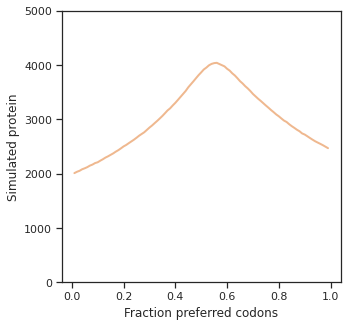

In [9]:
sns.set_theme(style="ticks", palette=None)
sns.lineplot(data=df_trna_1_1_odds_ratio_0001, x="fraction_preferred", y="protein", color="#efb88f", linewidth=2)
#plt.xscale("log")
plt.xlabel("Fraction preferred codons")
plt.ylabel("Simulated protein")
plt.ylim(0, 5000)
#plt.savefig(f"../plots/{date}/trna_6_4_charging_0001.png", bbox_inches="tight")

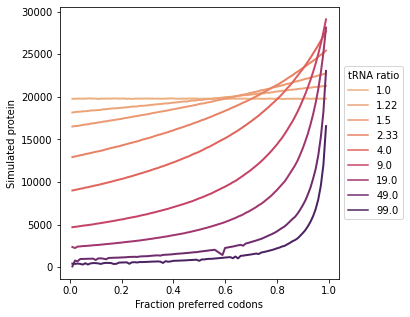

In [21]:
rcParams['figure.figsize'] = 5, 5
norm = LogNorm()
sns.lineplot(data=df_all_trna_1, x="fraction_preferred", y="protein", hue="tRNA_odds", hue_norm=norm, legend="full", palette="flare", linewidth=2)
#plt.xscale("log")
plt.xlabel("Fraction preferred codons")
plt.ylabel("Simulated protein")
plt.legend(title="tRNA ratio", loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"../plots/{date}/trna_all_charging_1.png", bbox_inches="tight")

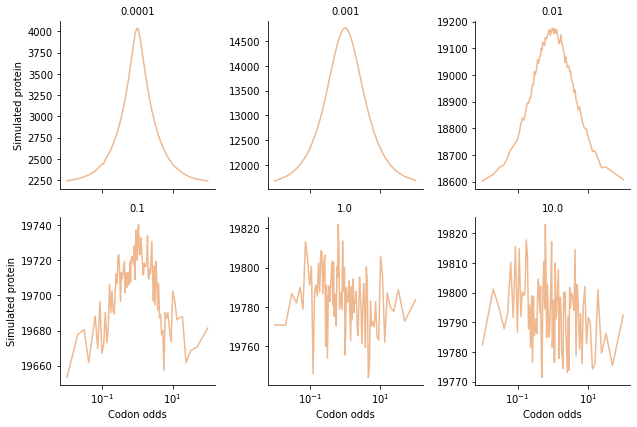

In [141]:
g = sns.FacetGrid(df_trna_1_1_odds_all, col="chrg_init_ratio", col_wrap=3, sharey=False, height=3, aspect=1)
g.map_dataframe(sns.lineplot, "codon_odds", "protein", color="#efb88f")
g.set_titles("{col_name}")
plt.xscale("log")
g.set_axis_labels("Codon odds", "Simulated protein")
plt.savefig(f"../plots/{date}/trna_1_1_all.png")

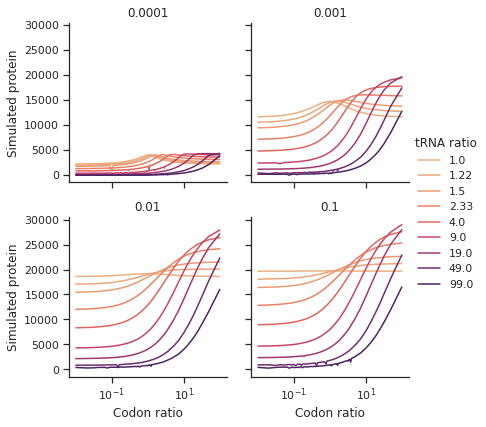

In [55]:
sns.set_theme(style="ticks", palette=None)
g = sns.FacetGrid(df_ratio_less_1, col="chrg_init_ratio", col_wrap=2, sharey=True, height=3, aspect=1)
g.map_dataframe(sns.lineplot, "codon_odds", "protein", hue="tRNA_odds", hue_norm=norm, legend="full", palette="flare")
g.add_legend(title="tRNA ratio")
g.set_titles("{col_name}")
plt.xscale("log")
g.set_axis_labels("Codon ratio", "Simulated protein")
plt.savefig(f"../plots/{date}/grid_no_background.png", bbox_inches="tight")

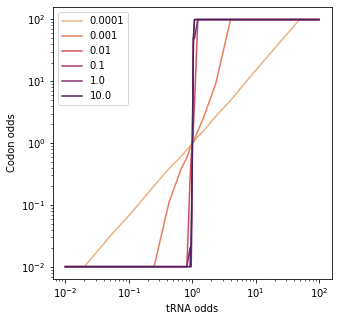

In [145]:
ratios = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
df_ratio_less_1 = df_master.loc[df_master['chrg_init_ratio'].isin(ratios)]
max_protein = df_ratio_less_1.loc[df_ratio_less_1.groupby(['tRNA_odds', "chrg_init_ratio"]).protein.idxmax()].reset_index()
max_protein
norm = LogNorm()
sns.lineplot(data=max_protein, x="tRNA_odds", y="codon_odds", hue='chrg_init_ratio', hue_norm=norm, palette="flare")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("tRNA odds")
plt.ylabel("Codon odds")
plt.legend(title="")
plt.savefig(f"../plots/{date}/max.png")

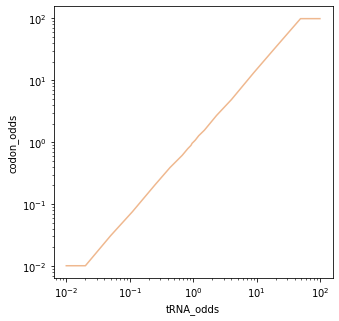

In [146]:
max_protein_001 = max_protein[(max_protein["chrg_init_ratio"]  == 0.0001)]
rcParams['figure.figsize'] = [5, 5]
sns.lineplot(data=max_protein_001, x="tRNA_odds", y="codon_odds", color="#efb88f")
plt.xscale("log")
plt.yscale("log")
plt.savefig(f"../plots/{date}/max_0001.png")

In [ ]:
df_master = pd.read_csv(f"../processed_data/{date}-averages-500-s.csv")
df_master['codon_odds'] = df_master.apply(lambda row: row.codon_comp/(100 - row.codon_comp), axis = 1)
df_master['tRNA_odds'] = df_master.apply(lambda row: row.tRNA_prop/(100 - row.tRNA_prop), axis = 1)
df_master["tRNA_charging_rate"] = df_master["tRNA_charging_rate"].astype(float) 
df_master['chrg_init_ratio'] = df_master["tRNA_charging_rate"] / ribosome_binding_rate
df_master = df_master.round({"tRNA_odds": 2})
df_1_1 = df_master[(df_master.tRNA_odds == 1.5)]

species = ["__ribosome", "TTT_charged", "ATA_charged"]
df_1_1_rib_charged_trna = df_1_1.loc[df_1_1['species'].isin(species)]

df_1_1_rib_charged_trna[df_1_1_rib_charged_trna["codon_comp"] == 70]

,Unnamed: 0,species,protein,codon_comp,tRNA_prop,tRNA_charging_rate,codon_odds,tRNA_odds,chrg_init_ratio
9114,9114,ATA_charged,4.25,1,60,10.0,0.010101,1.5,0.0001
9116,9116,TTT_charged,59.75,1,60,10.0,0.010101,1.5,0.0001
9119,9119,__ribosome,2.00,1,60,10.0,0.010101,1.5,0.0001
9121,9121,ATA_charged,4.00,2,60,10.0,0.020408,1.5,0.0001
9123,9123,TTT_charged,58.50,2,60,10.0,0.020408,1.5,0.0001
...,...,...,...,...,...,...,...,...,...
78108,78108,TTT_charged,59.20,98,60,1000000.0,49.000000,1.5,10.0000
78111,78111,__ribosome,23.40,98,60,1000000.0,49.000000,1.5,10.0000
78113,78113,ATA_charged,40.00,99,60,1000000.0,99.000000,1.5,10.0000
78115,78115,TTT_charged,59.00,99,60,1000000.0,99.000000,1.5,10.0000


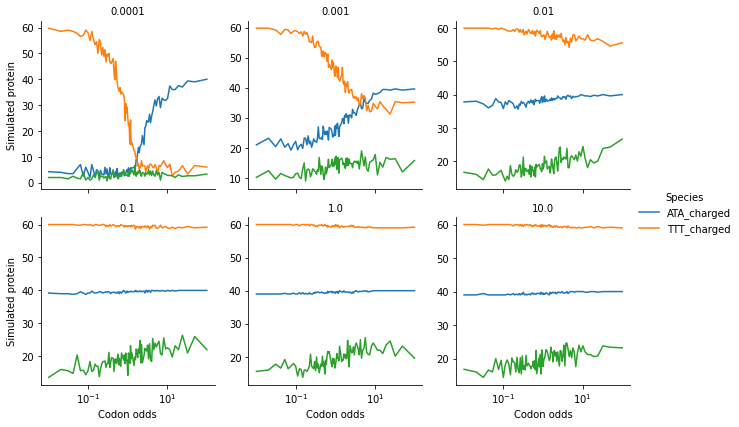

In [44]:
g = sns.FacetGrid(df_1_1_rib_charged_trna, col="chrg_init_ratio", col_wrap=3, sharey=False, height=3, aspect=1)
g.map_dataframe(sns.lineplot, "codon_odds", "protein", hue="species", legend="full")
g.add_legend(title="Species")
g.set_titles("{col_name}")
plt.xscale("log")
g.set_axis_labels("Codon odds", "Simulated protein")

In [56]:
df_master = pd.read_csv(f"../processed_data/{date}-averages-500-s.csv")
df_master['codon_odds'] = df_master.apply(lambda row: row.codon_comp/(100 - row.codon_comp), axis = 1)
df_master['tRNA_odds'] = df_master.apply(lambda row: row.tRNA_prop/(100 - row.tRNA_prop), axis = 1)
df_master['fraction_preferred'] = df_master.apply(lambda row: row.codon_comp/100, axis = 1)
df_master["tRNA_charging_rate"] = df_master["tRNA_charging_rate"].astype(float) 
df_master['chrg_init_ratio'] = df_master["tRNA_charging_rate"] / ribosome_binding_rate
df_master = df_master.round({"tRNA_odds": 2})
df_1_1 = df_master[(df_master.tRNA_odds == 1.22)]

species = ["__ribosome", "TTT_charged", "ATA_charged"]
df_1_1_rib_charged_trna = df_1_1.loc[df_1_1['species'].isin(species)]
df_1_1_rib_charged_trna

,Unnamed: 0,species,protein,codon_comp,tRNA_prop,tRNA_charging_rate,codon_odds,tRNA_odds,fraction_preferred,chrg_init_ratio
8463,8463,ATA_charged,3.0,1,55,10.0,0.010101,1.22,0.01,0.0001
8465,8465,TTT_charged,55.0,1,55,10.0,0.010101,1.22,0.01,0.0001
8468,8468,__ribosome,2.5,1,55,10.0,0.010101,1.22,0.01,0.0001
8470,8470,ATA_charged,4.5,2,55,10.0,0.020408,1.22,0.02,0.0001
8472,8472,TTT_charged,54.5,2,55,10.0,0.020408,1.22,0.02,0.0001
...,...,...,...,...,...,...,...,...,...,...
77457,77457,TTT_charged,54.0,98,55,1000000.0,49.000000,1.22,0.98,10.0000
77460,77460,__ribosome,19.0,98,55,1000000.0,49.000000,1.22,0.98,10.0000
77462,77462,ATA_charged,45.0,99,55,1000000.0,99.000000,1.22,0.99,10.0000
77464,77464,TTT_charged,54.0,99,55,1000000.0,99.000000,1.22,0.99,10.0000


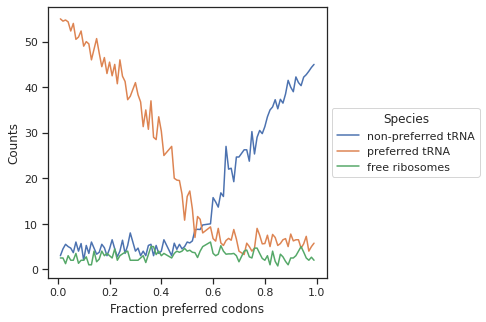

In [58]:
df_1_1_rib_charged_trna = df_1_1_rib_charged_trna[(df_1_1_rib_charged_trna.chrg_init_ratio == 0.0001)]

df_1_1_rib_charged_trna["species"] = df_1_1_rib_charged_trna["species"].replace({"__ribosome": "free ribosomes"})
df_1_1_rib_charged_trna["species"] = df_1_1_rib_charged_trna["species"].replace({"ATA_charged": "non-preferred tRNA"})
df_1_1_rib_charged_trna["species"] = df_1_1_rib_charged_trna["species"].replace({"TTT_charged": "preferred tRNA"})

sns.lineplot(data=df_1_1_rib_charged_trna, x="fraction_preferred", y="protein", hue="species")
#plt.xscale("log")
plt.xlabel("Fraction preferred codons")
plt.ylabel("Counts")
plt.legend(title="Species", loc='center left', bbox_to_anchor=(1, 0.5))
#plt.ylim(0, 5000)
plt.savefig(f"../plots/{date}/trna_6_4_charging_0001_species.png", bbox_inches="tight")

In [ ]:
print("hello world")